In [2]:
import pandas as pd

# 1. Carregar o arquivo (ajuste o nome se necessário)
df = pd.read_csv('sih_cnv_niuf204001177_9_9_253.csv', sep=';', encoding='latin1')

# 2. Limpeza: Remover a linha que contém apenas o ano "2023" ou "2024" (totais anuais)
# Queremos apenas as linhas que têm a barra (ex: jan/23)
df = df[df['Ano/mês atendimento'].str.contains('/', na=False)]

# 3. O "Melt": Transformar colunas de estados em uma única coluna 'UF'
# Mantemos 'Ano/mês atendimento' e transformamos o resto
df_longo = df.melt(id_vars=['Ano/mês atendimento'],
                   var_name='UF',
                   value_name='Internacoes')

# 4. Remover a coluna 'Total' se ela tiver vindo no meio dos estados
df_longo = df_longo[df_longo['UF'] != 'Total']

# 5. Converter 'Internacoes' para número (às vezes o CSV traz como texto)
df_longo['Internacoes'] = pd.to_numeric(df_longo['Internacoes'], errors='coerce')

print("✅ Dados organizados para análise!")
print(df_longo.head())

✅ Dados organizados para análise!
  Ano/mês atendimento  UF  Internacoes
0              jan/23  RO        635.0
1              fev/23  RO        965.0
2          Março/2023  RO       1616.0
3              abr/23  RO       2090.0
4              mai/23  RO       2050.0


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(2025-10-15 00:00:00, 392.35126548745853, 'Início da Predição')

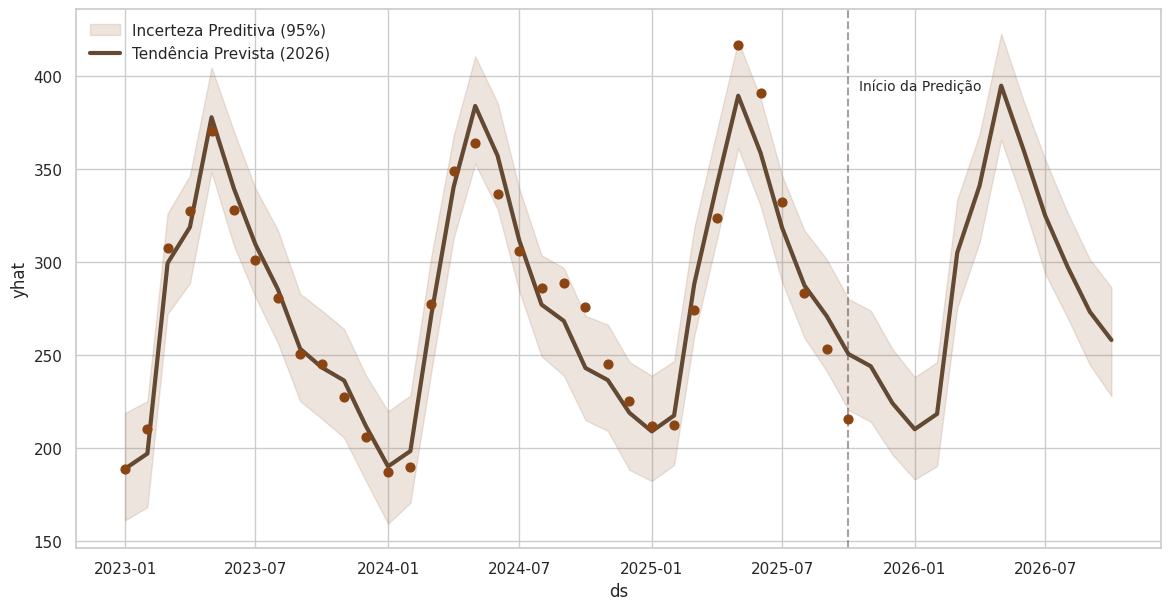

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

# 1. Preparação dos dados consolidados (até Out/2025)
df_clean = df_regiao[df_regiao['Data'] < '2025-11-01'].copy()
df_prophet = df_clean.groupby('Data')['Taxa_100k'].sum().reset_index()
df_prophet.columns = ['ds', 'y']

# 2. Configuração do Modelo Prophet
# Mantemos a sazonalidade anual ativada para ele entender os ciclos de inverno
modelo = Prophet(yearly_seasonality=True, interval_width=0.95)
modelo.fit(df_prophet)

# 3. Projetando até Outubro de 2026
# De Out/2025 até Out/2026 são 12 meses
futuro_estendido = modelo.make_future_dataframe(periods=12, freq='MS')
previsao_estendida = modelo.predict(futuro_estendido)

# 4. Visualização de Alto Impacto
plt.figure(figsize=(14, 7))

# Sombra da Incerteza (Intervalo de Confiança)
plt.fill_between(previsao_estendida['ds'],
                 previsao_estendida['yhat_lower'],
                 previsao_estendida['yhat_upper'],
                 color='#A67B5B', alpha=0.2, label='Incerteza Preditiva (95%)')

# Linha de Tendência Estendida
sns.lineplot(data=previsao_estendida, x='ds', y='yhat',
             color='#634832', linewidth=3, label='Tendência Prevista (2026)')

# Dados Reais Consolidados
plt.scatter(df_prophet['ds'], df_prophet['y'],
            color='#8B4513', s=40, label='Dados Consolidados (Histórico)', zorder=5)

# Linha vertical indicando onde termina o real e começa o futuro
plt.axvline(x=pd.to_datetime('2025-10-01'), color='#5D4037', linestyle='--', alpha=0.5)
plt.text(pd.to_datetime('2025-10-15'), plt.ylim()[1]*0.9, 'Início da Predição', fontsize=10)

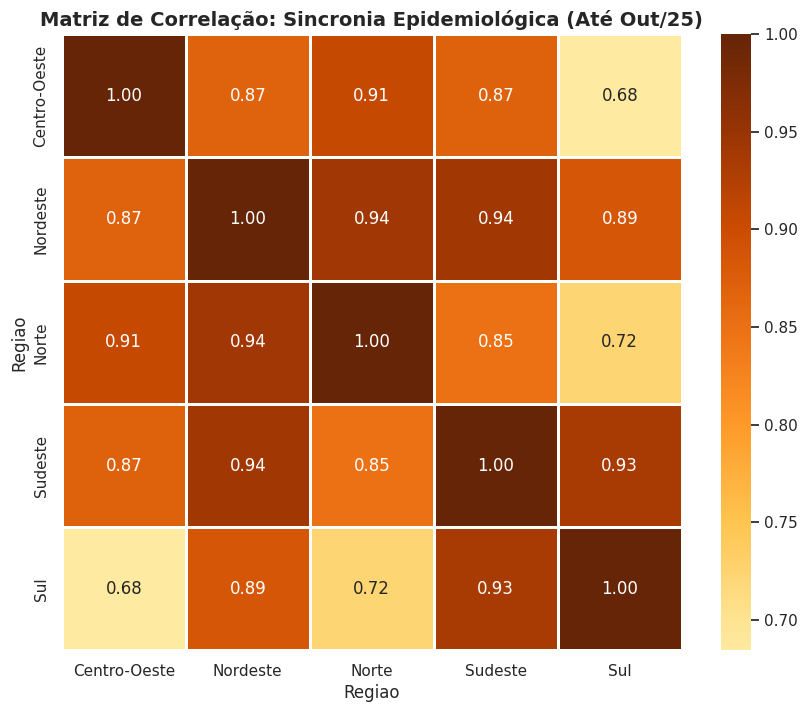

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


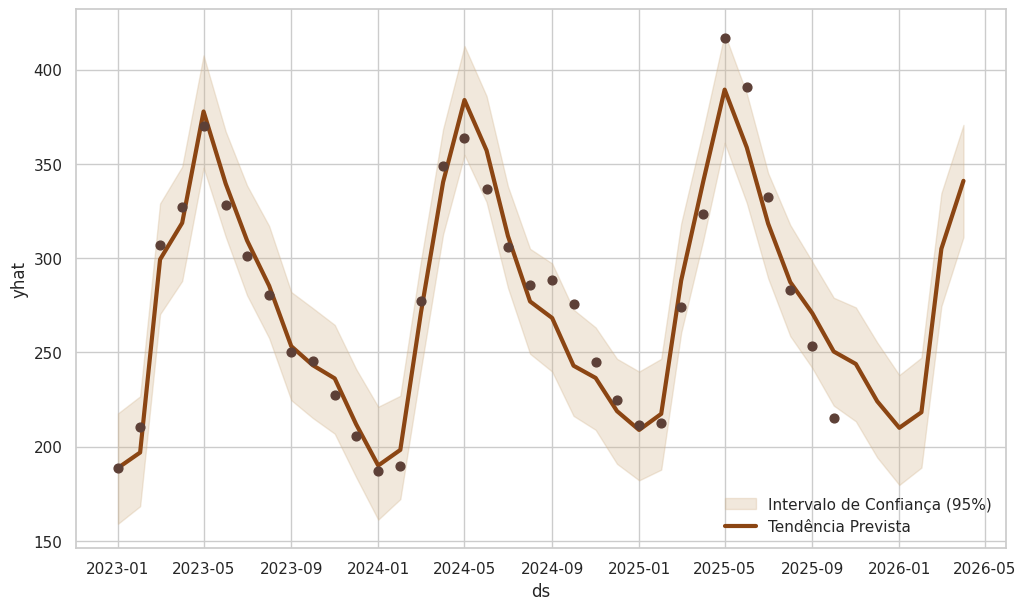

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

# 1. Filtro de Segurança: Removendo novembro de 2025
# Vamos garantir que trabalhamos apenas com dados completos
df_clean = df_regiao[df_regiao['Data'] < '2025-11-01'].copy()

# 2. MATRIZ DE CORRELAÇÃO (Sincronia Provada)
df_pivot = df_clean.pivot(index='Data', columns='Regiao', values='Taxa_100k')
corr_matrix = df_pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrBr', center=0.8, fmt=".2f", linewidths=1)
plt.title('Matriz de Correlação: Sincronia Epidemiológica (Até Out/25)', fontsize=14, fontweight='bold')
plt.show()

# 3. PREDIÇÃO PROPHET (Sem o ruído de novembro)
df_prophet = df_clean.groupby('Data')['Taxa_100k'].sum().reset_index()
df_prophet.columns = ['ds', 'y']

modelo = Prophet(yearly_seasonality=True, interval_width=0.95)
modelo.fit(df_prophet)

# Projetando 6 meses a partir de Outubro
futuro = modelo.make_future_dataframe(periods=6, freq='MS')
previsao = modelo.predict(futuro)

# 4. VISUAL FINAL: Elegância e Rigor
plt.figure(figsize=(12, 7))

# Sombra da Incerteza (Intervalo de Confiança)
plt.fill_between(previsao['ds'], previsao['yhat_lower'], previsao['yhat_upper'],
                 color='#D2B48C', alpha=0.3, label='Intervalo de Confiança (95%)')

# Linha de Tendência (O "Caminho" da doença)
sns.lineplot(data=previsao, x='ds', y='yhat', color='#8B4513', linewidth=3, label='Tendência Prevista')

# Dados Reais (Pontos)
plt.scatter(df_prophet['ds'], df_prophet['y'], color='#5D4037', s=40, label='Dados Consolidados', zorder=5)

plt.show()

INFO:prophet:Making 12 forecasts with cutoffs between 2024-07-08 00:00:00 and 2025-06-03 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


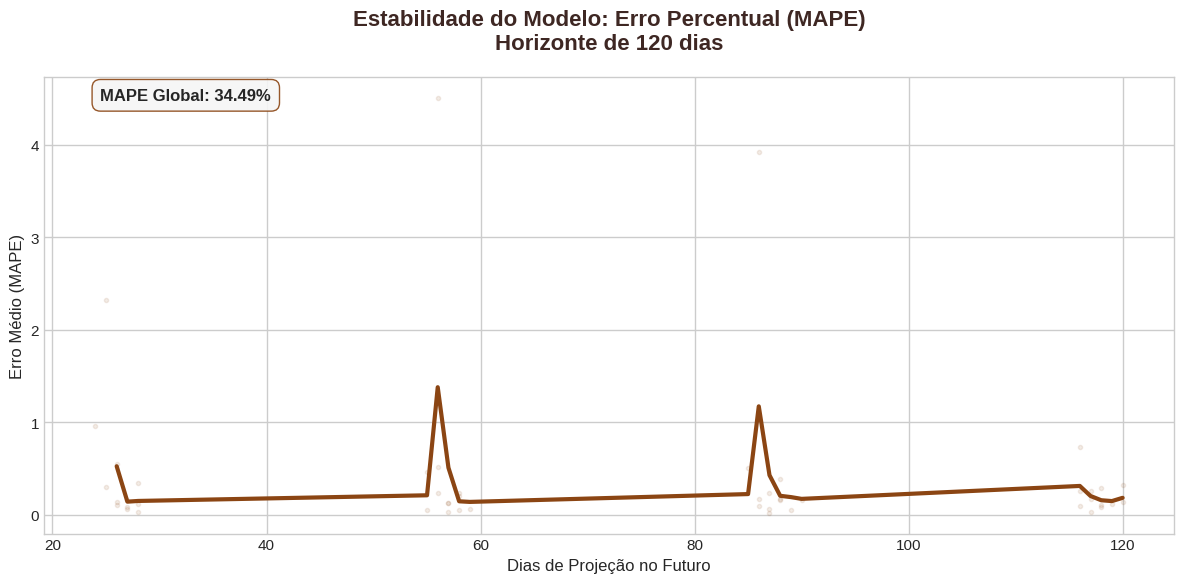

In [23]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

df_cv = cross_validation(modelo, initial='540 days', period='30 days', horizon='120 days')

df_p = performance_metrics(df_cv)

import matplotlib.pyplot as plt
from prophet.plot import plot_cross_validation_metric
import matplotlib.collections as mcoll

plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(12, 6))

plot_cross_validation_metric(df_cv, metric='mape', ax=plt.gca())

ax = plt.gca()

for line in ax.get_lines():
    line.set_color('#8B4513') # Marrom profundo
    line.set_linewidth(3)

for artist in ax.collections:
    if isinstance(artist, mcoll.PathCollection):
        artist.set_color('#D2B48C') # Bege/Areia
        artist.set_alpha(0.3)

# 4. Finalização Estética
plt.title('Estabilidade do Modelo: Erro Percentual (MAPE)\nHorizonte de 120 dias',
          fontsize=16, fontweight='bold', color='#3E2723', pad=20)
plt.xlabel('Dias de Projeção no Futuro', fontsize=12)
plt.ylabel('Erro Médio (MAPE)', fontsize=12)

plt.text(0.05, 0.95, f'MAPE Global: {df_p["mape"].mean()*100:.2f}%',
         transform=ax.transAxes, fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.5", fc="#F5F5F5", ec="#8B4513", alpha=0.9))

plt.tight_layout()
plt.show()